In [1]:
#import os
#os.environ['PYSPARK_PYTHON'] = '/opt/conda/bin/python'

In [2]:
import subprocess
import sys
import os
import re
import time
import atexit
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, udf, lag, date_add, explode, lit, unix_timestamp
from pyspark.sql.functions import month, weekofyear, dayofmonth
from pyspark.sql.types import *
from pyspark.sql.types import DateType
from pyspark.sql.dataframe import *
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.ml.classification import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.feature import StandardScaler, PCA, RFormula
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import col, avg

In [3]:
from pyspark import sql, SparkConf, SparkContext

conf = SparkConf().setAppName("Read_CSV")
sc = SparkContext(conf=conf)
sqlContext = sql.SQLContext(sc)

In [4]:
dataFile = "/home/rubens/Documents/Python/DadosTeseLogit.csv"
dataFileSep = ','
df = sqlContext.read.csv(dataFile, header=True, sep=dataFileSep, inferSchema=True, nanValue="", mode='PERMISSIVE')

In [5]:
df.count(), len(df.columns)

(98, 31)

In [6]:
df.show(1)

+------------+------------+-----------+------------+----------+----------+---------+-----------+-----------+--------+-----------+-----------+-----------+----------+-----------+----------+----------+----------+--------+----------+------------+---------+----------+-----------+-----------+----------+-----------+-----------+--------+-----------+--------+
|c0_objetivos|c0_responsab|c0_esperado|c0_participa|c0_coopera|c0_cuidado|c0_prazer|c0_presente|c0_personal|c0_saber|c0_bemestar|c0_desagrad|c0_problema|c0_instala|c0_disponib|c0_equipam|c0_higiene|c0_pontual|c0_dados|c0_atencao|c0_confianca|c0_ajudar|c0_honesto|c0_preocupa|c0_respfunc|c0_adaptar|c0_positiva|c0_estimula|c0_preco|c0_recomend|selected|
+------------+------------+-----------+------------+----------+----------+---------+-----------+-----------+--------+-----------+-----------+-----------+----------+-----------+----------+----------+----------+--------+----------+------------+---------+----------+-----------+-----------+-------

In [7]:
df.dtypes

[('c0_objetivos', 'double'),
 ('c0_responsab', 'double'),
 ('c0_esperado', 'int'),
 ('c0_participa', 'int'),
 ('c0_coopera', 'int'),
 ('c0_cuidado', 'double'),
 ('c0_prazer', 'int'),
 ('c0_presente', 'int'),
 ('c0_personal', 'int'),
 ('c0_saber', 'int'),
 ('c0_bemestar', 'int'),
 ('c0_desagrad', 'double'),
 ('c0_problema', 'double'),
 ('c0_instala', 'int'),
 ('c0_disponib', 'int'),
 ('c0_equipam', 'int'),
 ('c0_higiene', 'double'),
 ('c0_pontual', 'int'),
 ('c0_dados', 'int'),
 ('c0_atencao', 'int'),
 ('c0_confianca', 'double'),
 ('c0_ajudar', 'double'),
 ('c0_honesto', 'int'),
 ('c0_preocupa', 'int'),
 ('c0_respfunc', 'int'),
 ('c0_adaptar', 'int'),
 ('c0_positiva', 'double'),
 ('c0_estimula', 'int'),
 ('c0_preco', 'int'),
 ('c0_recomend', 'double'),
 ('selected', 'int')]

In [8]:
df = df.dropna(how='any')

In [9]:
def fill_with_mean(df, exclude=set()): 
    stats = df.agg(*(
        avg(c).alias(c) for c in df.columns if c not in exclude
    ))
    return df.na.fill(stats.first().asDict())

fill_with_mean(df, ["c0_preco"])

DataFrame[c0_objetivos: double, c0_responsab: double, c0_esperado: int, c0_participa: int, c0_coopera: int, c0_cuidado: double, c0_prazer: int, c0_presente: int, c0_personal: int, c0_saber: int, c0_bemestar: int, c0_desagrad: double, c0_problema: double, c0_instala: int, c0_disponib: int, c0_equipam: int, c0_higiene: double, c0_pontual: int, c0_dados: int, c0_atencao: int, c0_confianca: double, c0_ajudar: double, c0_honesto: int, c0_preocupa: int, c0_respfunc: int, c0_adaptar: int, c0_positiva: double, c0_estimula: int, c0_preco: int, c0_recomend: double, selected: int]

In [10]:
from pyspark.sql.types import *

df.createOrReplaceTempView("df1")

sqlStatement = """
    SELECT c0_atencao, c0_esperado, c0_preco FROM df1 WHERE df1.selected=='1'
"""
plotdata = sqlContext.sql(sqlStatement).toPandas();

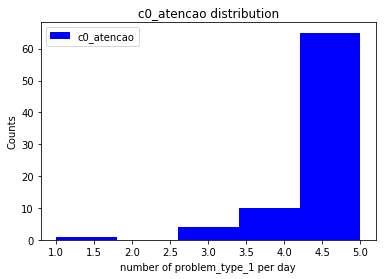

<Figure size 288x288 with 0 Axes>

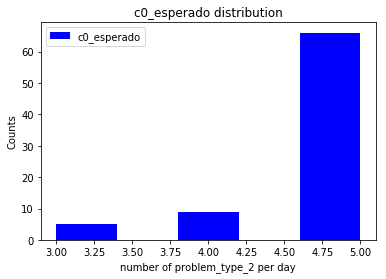

<Figure size 288x288 with 0 Axes>

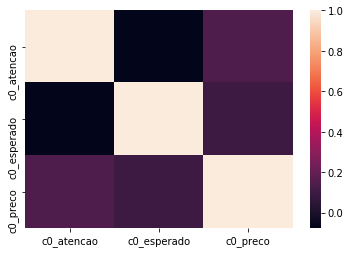

In [11]:


%matplotlib inline

# show histogram distribution of some features
ax1 = plotdata[['c0_atencao']].plot(kind='hist', bins=5, facecolor='blue')
ax1.set_title('c0_atencao distribution')
ax1.set_xlabel('number of problem_type_1 per day'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

ax1 = plotdata[['c0_esperado']].plot(kind='hist', bins=5, facecolor='blue')
ax1.set_title('c0_esperado distribution')
ax1.set_xlabel('number of problem_type_2 per day'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()


# show correlation matrix heatmap to explore some potential interesting patterns
corr = plotdata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [12]:
df.groupby('c0_atencao').count().show()


+----------+-----+
|c0_atencao|count|
+----------+-----+
|         1|    1|
|         3|    8|
|         5|   71|
|         4|   17|
|         2|    1|
+----------+-----+



In [13]:
import pyspark.sql.functions as F
import time
import pandas as pd
import subprocess
import sys
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import datetime
import atexit

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import col,udf,lag,date_add,explode,lit,concat,unix_timestamp,sum, abs
from pandas import DataFrame
from pyspark.sql.dataframe import *
from pyspark.ml.classification import *
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.sql.types import DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import Row
from pyspark.ml import Pipeline, PipelineModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, RFormula
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc
from pyspark.sql.functions import month, weekofyear, dayofmonth
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import PCA
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql.types import DoubleType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
df.select('c0_recomend').describe().show()

+-------+------------------+
|summary|       c0_recomend|
+-------+------------------+
|  count|                98|
|   mean| 5.840768040816339|
| stddev|1.3793775482272992|
|    min|         1.5481445|
|    max|          6.471247|
+-------+------------------+



In [15]:
df.groupby('selected').count().show()

+--------+-----+
|selected|count|
+--------+-----+
|       1|   80|
|       0|   18|
+--------+-----+



In [16]:
input_features=df.columns[2:28]
y=df.columns[30]
label_var = ['selected']

In [17]:
va = VectorAssembler(inputCols=(input_features), outputCol='features')

In [18]:
va2 = VectorAssembler(inputCols=([y]), outputCol='label')

In [19]:
df = va.transform(df)
df2 = va2.transform(df.withColumn("selected",df["selected"].cast("int")))

In [20]:
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", maxCategories=10).fit(df)

In [21]:
labelIndexer = StringIndexer(inputCol="selected", outputCol="indexedLabel").fit(df2)

In [22]:
#changedTypedf = df.withColumn("c0_atencao",df["c0_atencao"].cast("int"))

In [23]:
(trainingData, testData) = df.randomSplit([0.7, 0.3])

In [24]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [25]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [26]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

model = pipeline.fit(trainingData)

In [27]:
predictions = model.transform(testData)


In [28]:
predictions.groupby('indexedLabel', 'prediction').count().show()

+------------+----------+-----+
|indexedLabel|prediction|count|
+------------+----------+-----+
|         1.0|       0.0|    4|
|         0.0|       0.0|   21|
+------------+----------+-----+



In [29]:
predictionAndLabels = predictions.select("indexedLabel", "prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %g" % metrics.areaUnderROC)
print("Area under PR = %g\n" % metrics.areaUnderPR)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction")
print("Accuracy = %g" % evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("Weighted Precision = %g" % evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"}))
print("Weighted Recall = %g" % evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"}))
print("F1 = %g" % evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))



Area under ROC = 0
Area under PR = 0

Accuracy = 0.84
Weighted Precision = 0.7056
Weighted Recall = 0.84
F1 = 0.766957


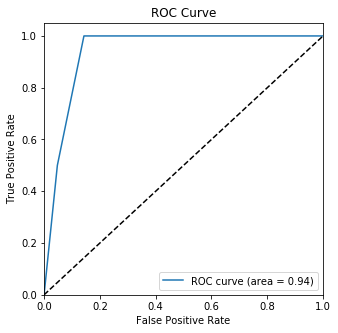

In [30]:
%matplotlib inline
predictions_pddf = predictions.select('indexedLabel','probability').toPandas()
labels = predictions_pddf["indexedLabel"]
prob = []
for dv in predictions_pddf["probability"]:
    prob.append(dv.values[1])
     
fpr, tpr, thresholds = roc_curve(labels, prob, pos_label=1.0);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()